# The following model detects sarcasm, based on text and emojis.

## STEP 1: Setup & Imports

In [ ]:
# ==========================================
# STEP 1 — Setup & Imports
# ==========================================
!pip -q install emoji pandas scikit-learn matplotlib seaborn transformers accelerate pillow torchvision nlpaug

import os, re, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji as emoji_lib
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from transformers import AutoTokenizer, AutoModel, CLIPVisionModel, get_linear_schedule_with_warmup
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Reproducibility function: ensures consistent results across runs
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin = torch.cuda.is_available()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.8 MB/s eta 0:00:00


## STEP 2: Download Dataset (isSarcasmEval)

In [ ]:
# ==========================================
# STEP 2 — Download Dataset (iSarcasmEval)
# ==========================================
!rm -rf iSarcasmEval
!git clone -q https://github.com/iabufarha/iSarcasmEval.git
print("Dataset downloaded.")


Dataset downloaded.


## STEP 3: Load Data & Train/Validation Split (No leakage)

In [ ]:
# ==========================================
# STEP 3 — Load Data & Train/Val Split (No leakage)
# ==========================================
df_train = pd.read_csv("iSarcasmEval/train/train.En.csv")[["tweet", "sarcastic"]].rename(
    columns={"tweet":"text", "sarcastic":"label"} # Keep only the tweet text and sarcasm label
)
df_test = pd.read_csv("iSarcasmEval/test/task_A_En_test.csv")[["text", "sarcastic"]].rename(
    columns={"text":"text", "sarcastic":"label"} # We need the label for evaluations
)

# Clean empty rows
df_train = df_train.dropna(subset=["text"])
df_train = df_train[df_train["text"].str.strip() != ""].reset_index(drop=True)

df_test = df_test.dropna(subset=["text"])
df_test = df_test[df_test["text"].str.strip() != ""].reset_index(drop=True)

# Split the training set into train (80%) and validation (20%) subsets
train_df, val_df = train_test_split(
    df_train, test_size=0.2, random_state=42, stratify=df_train["label"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print(f"Loaded: Train={len(df_train)} | Test={len(df_test)}")
print(f"Split : Train={len(train_df)} | Val={len(val_df)} | Test={len(df_test)}")
print("Train label distribution:", train_df["label"].value_counts().to_dict())


Loaded: Train=3467 | Test=1400
Split : Train=2773 | Val=694 | Test=1400
Train label distribution: {0: 2080, 1: 693}


## STEP 4: Quick Data Analysis (Train-focused)

--- DATA ANALYSIS SUMMARY (TRAIN) ---
Train=2773 | Val=694 | Test=1400
Class balance (TRAIN): NonSar=2080, Sar=693 (24.99%)
NOTE: Imbalance -> report F1 for sarcastic class (label=1).
Emoji coverage: Train=534 (19.26%) | Val=135 (19.45%) | Test=301 (21.50%)
Top 5 Emojis (TRAIN): 😭, 😂, ❤, 🙃, 🏻
Avg words (TRAIN): 18.8 | Max words: 58


/tmp/ipython-input-3742475490.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipython-input-3742475490.py:109: UserWarning: Glyph 128579 (\N{UPSIDE-DOWN FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3742475490.py:109: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3742475490.py:109: UserWarning: Glyph 129402 (\N{FACE WITH PLEADING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3742475490.py:109: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3742475490.py:109: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr

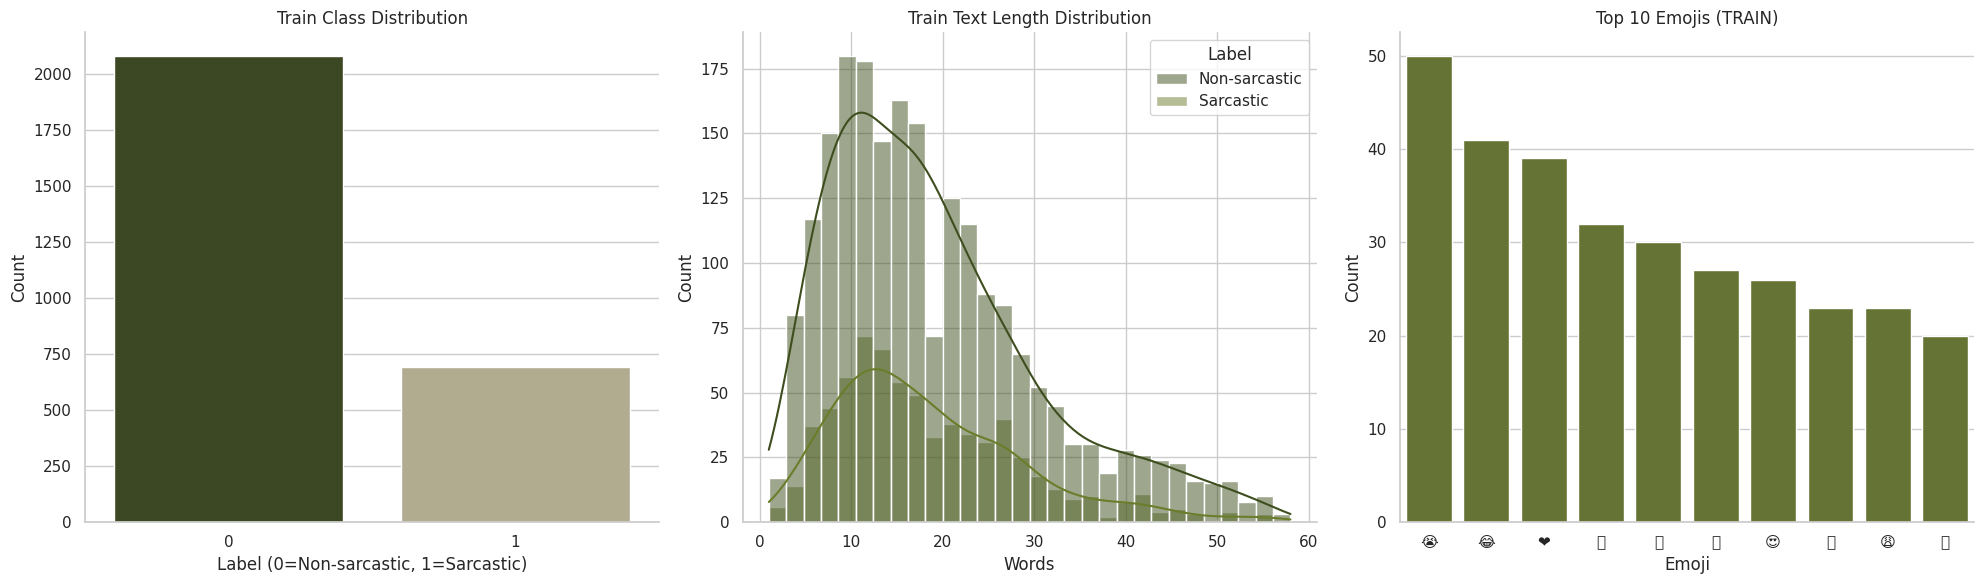

In [ ]:
# ==========================================
# STEP 4 — Quick Data Analysis (Train-focused)
# ==========================================

# Extracts all emojis from the text
def extract_emojis(text):
    return [c for c in str(text) if c in emoji_lib.EMOJI_DATA]


# Computes how many texts contain at least one emoji
# Returns the sum of the textx and the mean percentage
def emoji_coverage(df):
    has = df["text"].apply(lambda t: any(c in emoji_lib.EMOJI_DATA for c in str(t)))
    return int(has.sum()), float(has.mean()*100)

train_eda = train_df.copy()

# Compute word count per tweet
train_eda["word_count"] = train_eda["text"].apply(lambda x: len(str(x).split()))

# Extract emojis per tweet
train_eda["emojis_list"] = train_eda["text"].apply(extract_emojis)

counts = train_eda["label"].value_counts()
sar = int(counts.get(1,0))
nonsar = int(counts.get(0,0))
# Compute class distribution
sar_perc = sar/len(train_eda)*100

tr_n, tr_p = emoji_coverage(train_df)
va_n, va_p = emoji_coverage(val_df)
te_n, te_p = emoji_coverage(df_test)

# Most frequent emojis in training set
top_10 = Counter([e for sub in train_eda["emojis_list"] for e in sub]).most_common(10)

print("--- DATA ANALYSIS SUMMARY (TRAIN) ---")
print(f"Train={len(train_df)} | Val={len(val_df)} | Test={len(df_test)}")
print(f"Class balance (TRAIN): NonSar={nonsar}, Sar={sar} ({sar_perc:.2f}%)")
if sar_perc < 30:
    print("NOTE: Imbalance -> report F1 for sarcastic class (label=1).")

print(f"Emoji coverage: Train={tr_n} ({tr_p:.2f}%) | Val={va_n} ({va_p:.2f}%) | Test={te_n} ({te_p:.2f}%)")
if top_10:
    print("Top 5 Emojis (TRAIN):", ", ".join([x[0] for x in top_10[:5]]))

print(f"Avg words (TRAIN): {train_eda['word_count'].mean():.1f} | Max words: {train_eda['word_count'].max()}")

PALETTE = ["#6B7D2A", "#B7B08A", "#DCD6C6", "#3E4E1E"]

sns.set_theme(style="whitegrid", palette=PALETTE)
plt.rcParams["figure.figsize"] = (12, 6)

olive_beige_cmap = LinearSegmentedColormap.from_list(
    "olive_beige",
    ["#DCD6C6", "#B7B08A", "#6B7D2A", "#3E4E1E"]
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Class Distribution
sns.countplot(
    x="label",
    data=train_eda,
    ax=axes[0],
    palette=["#3E4E1E", "#B7B08A"]  # olive / beige
)
axes[0].set_title("Train Class Distribution")
axes[0].set_xlabel("Label (0=Non-sarcastic, 1=Sarcastic)")
axes[0].set_ylabel("Count")

# Plot 2: Text Length Distribution
sns.histplot(
    data=train_eda,
    x="word_count",
    hue="label",
    kde=True,
    bins=30,
    ax=axes[1],
    palette=["#3E4E1E", "#6B7D2A"]
)
axes[1].set_title("Train Text Length Distribution")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Count")

leg = axes[1].get_legend()
if leg is not None:
    leg.set_title("Label")
    leg.texts[0].set_text("Non-sarcastic")
    leg.texts[1].set_text("Sarcastic")


# Plot 3: Top 10 Emojis
if top_10:
    sns.barplot(
        x=[e[0] for e in top_10],
        y=[e[1] for e in top_10],
        ax=axes[2],
        color="#6B7D2A"
    )
    axes[2].set_title("Top 10 Emojis (TRAIN)")
    axes[2].set_xlabel("Emoji")
    axes[2].set_ylabel("Count")
else:
    axes[2].text(0.5, 0.5, "No Emojis Found", ha="center", va="center")


sns.despine()
plt.tight_layout()
plt.show()



## STEP 5: Algorithm 1 (Adapted Preprocess) <br>
The following script provides preprocessed sets of training, validation and test data.

In [ ]:
# ==========================================
# STEP 5 — Algorithm 1 (Adapted Preprocess)
# Outputs: train_proc, val_proc, test_proc
# ==========================================
import nlpaug.augmenter.word as naw

slang_dict = {
    "u": "you", "r": "are", "ur": "your",
    "omg": "oh my god", "lol": "laugh out loud",
    "idk": "i do not know", "brb": "be right back",
    "gonna": "going to", "wanna": "want to",
    "im": "i am", "tbh": "to be honest"
}

# Performs cleaning without removing semantics
def minimal_preprocess(text):
    t = str(text).replace("\n"," ").strip()
    t = re.sub(r"http\S+|www\.\S+", "", t) # remove URLs
    t = re.sub(r"\s+", " ", t).strip() # normalize spaces
    return t

# Replaces slang words based on the slang_dict
def handle_slangs(text):
    return " ".join([slang_dict.get(w.lower(), w) for w in str(text).split()])

# Keeps raw text explicitly for emoji-to-image processing
def base_pipeline(df):
    out = df.dropna(subset=["text"]).copy()
    out = out[out["text"].str.strip() != ""].reset_index(drop=True)

    out["raw_text_for_emoji"] = out["text"]  # IMPORTANT: keep raw for emoji-image
    out["final_text"] = out["text"].apply(minimal_preprocess).apply(handle_slangs)
    return out[["final_text","raw_text_for_emoji","label"]]

# Augmentation ONLY on train
AUG_PROB = 0.2
aug = naw.SynonymAug(aug_src="wordnet") # synonym replacement

# Randomnly augments text with synonyms for robustness
def augment_text(text):
    if random.random() > AUG_PROB:
        return text
    try:
        # We leave short text as is
        if len(text.split()) > 5:
            return aug.augment(text)[0]
    except:
        pass
    return text

train_proc = base_pipeline(train_df)
train_proc["final_text"] = train_proc["final_text"].apply(augment_text)

val_proc  = base_pipeline(val_df)
test_proc = base_pipeline(df_test)

print(f"Algo1 done -> Train:{len(train_proc)} | Val:{len(val_proc)} | Test:{len(test_proc)}")
print("Sample RAW  :", train_proc["raw_text_for_emoji"].iloc[0])
print("Sample FINAL:", train_proc["final_text"].iloc[0])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is al

Algo1 done -> Train:2773 | Val:694 | Test:1400
Sample RAW  : If your website still has a google plus share button, forgive me if I’m not tripping over myself to take your information as credible or current.
Sample FINAL: If your website still has a google plus share button, forgive me if I’m not tripping over myself to take your information as credible or current.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

## STEP 6: Tokenizer + Text Dataset + Loaders <br>
The following script provides DataLoaders for training, validation and testing by using RoBERTa transformer as tokenizer.

In [ ]:
# ============================================
# STEP 6 — Tokenizer + Text Dataset + Loaders
# ============================================
MODEL_NAME = "roberta-base" # Pre-trained transformer
MAX_LEN = 128
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Handles text tokenization and samples for the model
class SarcasmTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["final_text"].tolist()
        self.raws  = df["raw_text_for_emoji"].tolist()
        self.labels = df["label"].astype(int).tolist() # binary labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts) # num of samples

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        raw  = str(self.raws[idx])
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Returns dictionary compatible with HuggingFace / Pytorch models
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "raw_text": raw
        }

# We wrap the data in DataLoader for efficient training
train_loader = DataLoader(SarcasmTextDataset(train_proc, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(SarcasmTextDataset(val_proc,   tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SarcasmTextDataset(test_proc,  tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False)

print("Text loaders ready.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Text loaders ready.


## STEP 7: Baseline Model (Paper-inspired) <br>
RoBERTa-based model that enriches contextual embeddings with stacked-attention blocks.

In [ ]:
# ==========================================
# STEP 7 — Baseline Model (Paper-inspired)
# RoBERTa + cascaded (MUltiHead Attention + DepthwiseConv) blocks
# ==========================================

# Combines self-attention for global content with deep convolution for local feature extraction
class AttnConvBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads=8, dropout=0.2):
        super().__init__()
        # MultiHead Self-attention layer
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_dim)

        # Depthwise 1D convolution (tokenwise local content)
        # groups=hidden_dim ensures depthwise operation
        self.dwconv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1, groups=hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, attention_mask):
        # attention_mask: 1 for token, 0 for padding
        # Convert to key padding mask expected by PyTorch MHA
        key_padding_mask = ~attention_mask.bool()  # True on PAD => ignore

        # Self-attention with residual connections
        attn_out, _ = self.mha(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.drop(attn_out))

        # Depthwise convolution with residual connection
        y = self.dwconv(x.permute(0,2,1)).permute(0,2,1)
        x = self.norm2(x + self.drop(y))
        return x

# Baseline Sarcasm Classifier
# Transformer encoder with stacked attention - convo blocks
class KhanBaselineModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=2, num_blocks=2, num_heads=8, dropout=0.2):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name) # pre-trained RoBERTs encoder
        self.hidden_dim = self.roberta.config.hidden_size  # IMPORTANT: used by variant

        # Stack of attention - convolution blocks
        self.blocks = nn.ModuleList([
            AttnConvBlock(self.hidden_dim, num_heads=num_heads, dropout=dropout)
            for _ in range(num_blocks)
        ])

        self.drop = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        # Extract contextualed token embeddings from RobERTa
        x = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Apply cascaded attention - convo blocks
        for blk in self.blocks:
            x = blk(x, attention_mask)
        cls = x[:, 0, :] # token representation for classifications
        return self.classifier(self.drop(cls))

print("Baseline model class ready.")


Baseline model class ready.


## STEP 8: Shared Utils (metrics + confusion matrix + eval)

In [ ]:
# ==========================================
# STEP 8 — Shared Utils (metrics + confusion matrix + eval)
# ==========================================

# Focuses on the sarcastic class
def compute_metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "rec": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
    }

def plot_cm(y_true, y_pred, title, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0.5, 1.5], ["Non-Sarcastic","Sarcastic"])
    plt.yticks([0.5, 1.5], ["Non-Sarcastic","Sarcastic"], rotation=0)
    plt.show()


# Model Evaluation: evaluated text-based model on a given DataLoader
def eval_text_model(model, loader, loss_fn):
    model.eval()
    losses, preds, labels_all, raws = [], [], [], []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch in loader:
            # Move batch to device
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            logits = model(ids, mask)
            loss = loss_fn(logits, labels)
            losses.append(loss.item())

            # Predicted class labels
            p = torch.argmax(logits, dim=1).cpu().numpy().tolist()
            preds.extend(p)
            labels_all.extend(labels.cpu().numpy().tolist())

            raws.extend(batch["raw_text"])

    metrics = compute_metrics(labels_all, preds)
    metrics["loss"] = float(np.mean(losses))
    return metrics, np.array(labels_all), np.array(preds), np.array(raws)


## STEP 9: Weighted Loss (handles imbalance) <br>
The following script addresses class imbalance with the help of an inverse-frequency weighted cross-entropy loss --> ensures that errors contribute more strongly during training.

In [ ]:
# ==========================================
# STEP 9 — Weighted Loss (handles imbalance)
# ==========================================

# Number of samples per class in the training set
cnt = Counter(train_proc["label"].tolist())
# This penalizes misclassification of rare samples more strongly
w0 = 1.0 / cnt[0]
w1 = 1.0 / cnt[1]
# Create weight tensor for CrossEntropyLoss
class_weights = torch.tensor([w0, w1], dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
print("Weighted loss enabled.")
print("Class counts:", dict(cnt))
print("Class weights:", class_weights.detach().cpu().numpy().tolist())


Weighted loss enabled.
Class counts: {1: 693, 0: 2080}
Class weights: [0.000480769231216982, 0.0014430014416575432]


## STEP 10: Train Baseline (validate on Val, test once)<br>
The following script trains the basline sarcasm model using weighted loss, selects the best checkpoint based on f1 score and performs a single evaluation (not biased) on the test set.

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Baseline...
Epoch 1/4 | train_loss=0.7357 | val_f1=0.3162 | val_acc=0.7507 | time=72.6s
Epoch 2/4 | train_loss=0.5987 | val_f1=0.4014 | val_acc=0.7507 | time=71.7s
Epoch 3/4 | train_loss=0.4053 | val_f1=0.4520 | val_acc=0.7450 | time=72.2s
Epoch 4/4 | train_loss=0.2560 | val_f1=0.4465 | val_acc=0.7392 | time=71.5s

Best VAL F1 (baseline): 0.4520

BASELINE — FINAL TEST METRICS: {'acc': 0.785, 'prec': 0.3365695792880259, 'rec': 0.52, 'f1': 0.4086444007858546, 'loss': 0.6905463922091506}


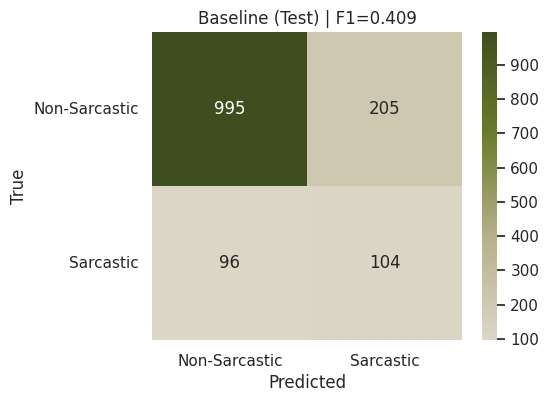

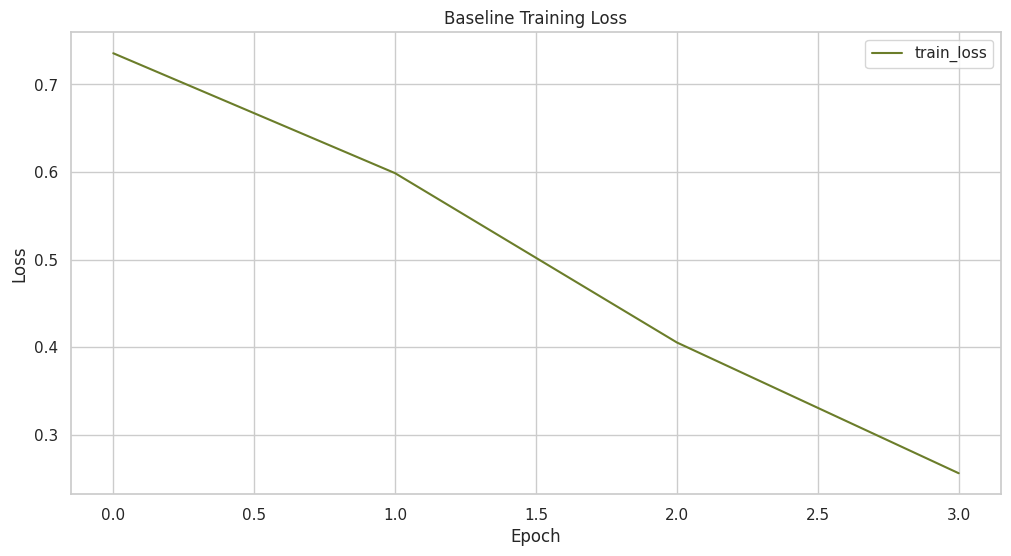

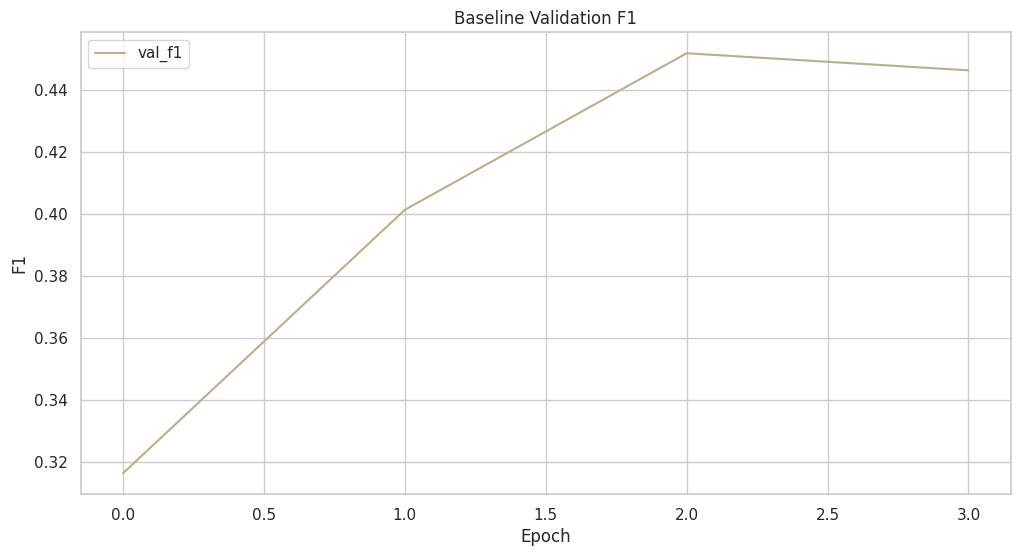

In [ ]:
# ==========================================
# STEP 10 — Train Baseline (validate on Val, test once)
# ==========================================
baseline_model = KhanBaselineModel(num_blocks=2, dropout=0.2).to(device)

optimizer = AdamW(baseline_model.parameters(), lr=2e-5, weight_decay=0.01)
epochs = 4
total_steps = len(train_loader) * epochs
# Linear learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Tracking best model
best_val_f1 = -1.0
best_state = None
hist_train_loss, hist_val_f1 = [], []

print("Training Baseline...")

# Training loop
for ep in range(1, epochs+1):
    t0 = time.time()
    baseline_model.train()
    running_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch to device
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits = baseline_model(ids, mask)
        loss = loss_fn(logits, labels)

        # Backpropagation
        loss.backward()

        # Gradient clipping for training stability
        torch.nn.utils.clip_grad_norm_(baseline_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    val_metrics, _, _, _ = eval_text_model(baseline_model, val_loader, loss_fn)

    hist_train_loss.append(train_loss)
    hist_val_f1.append(val_metrics["f1"])

    print(f"Epoch {ep}/{epochs} | train_loss={train_loss:.4f} | val_f1={val_metrics['f1']:.4f} | "
          f"val_acc={val_metrics['acc']:.4f} | time={time.time()-t0:.1f}s")

    # Saves best-performing model based on f1
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        best_state = {k: v.detach().cpu().clone() for k, v in baseline_model.state_dict().items()}

# restore best
if best_state is not None:
    baseline_model.load_state_dict(best_state)

print(f"\nBest VAL F1 (baseline): {best_val_f1:.4f}")

# Final evaluation on test set (evaluated once to avoid optimistic bias)
baseline_test_metrics, y_true_b, y_pred_b, raw_b = eval_text_model(baseline_model, test_loader, loss_fn)
print("\nBASELINE — FINAL TEST METRICS:", baseline_test_metrics)
plot_cm(
    y_true_b,
    y_pred_b,
    f"Baseline (Test) | F1={baseline_test_metrics['f1']:.3f}",
    cmap=olive_beige_cmap
)

plt.figure()
plt.plot(hist_train_loss, label="train_loss", color="#6B7D2A")
plt.title("Baseline Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

plt.figure()
plt.plot(hist_val_f1, label="val_f1", color="#B7B08A")
plt.title("Baseline Validation F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend()
plt.show()


## STEP 11: Multimodal Data (Emoji-image + emoji_count)<br>
The following script creates a multimodal dataset by augmenting textual inputs with visual emoji representations and a scalar emoji-count feature.

In [ ]:
# ==========================================
# STEP 11 — Multimodal Data (Emoji-image + emoji_count)
# ==========================================
# Emoji font for rendering
FONT_PATH = "NotoColorEmoji.ttf"
if not os.path.exists(FONT_PATH):
    !wget -q -O NotoColorEmoji.ttf https://github.com/googlefonts/noto-emoji/raw/main/fonts/NotoColorEmoji.ttf

IMG_SIZE = 224
try:
    emoji_font = ImageFont.truetype(FONT_PATH, 90)
    print("Emoji font loaded.")
except:
    emoji_font = None
    print("Emoji font not loaded. Emojis may render poorly on some envs.")

# Clip-stylle image preprocessing
clip_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275])
])

# Extracts emoji characters from text
def extract_emojis(text):
    return [c for c in str(text) if c in emoji_lib.EMOJI_DATA]

def emoji_count(text):
    return sum(1 for c in str(text) if c in emoji_lib.EMOJI_DATA)

# Renders up to 4 emojis into a 2x2 image grid
# If no emojis exist, a placeholder image is created
def render_emoji_grid(raw_text):
    """
    Up to 4 emojis in a 2x2 grid.
    If none -> NO_EMOJI image.
    """
    ems = extract_emojis(raw_text)
    img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0,0,0))
    draw = ImageDraw.Draw(img)

    if len(ems) == 0:
        draw.text((35, 90), "NO\nEMOJI", fill=(255,255,255))
        return clip_transform(img)

    # Limit to first 4 emojis
    ems = ems[:4]
    positions = [(30,25),(120,25),(30,125),(120,125)]
    for e,(x,y) in zip(ems, positions): # Draw emojis on the grid
        try:
            if emoji_font is not None:
                draw.text((x,y), e, font=emoji_font, embedded_color=True)
            else:
                draw.text((x,y), e, fill=(255,255,255))
        except:
            pass

    return clip_transform(img)

class SarcasmMultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["final_text"].tolist()
        self.raws  = df["raw_text_for_emoji"].tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        raw  = str(self.raws[idx])
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "pixel_values": render_emoji_grid(raw),
            # Scalar emoji count feature
            "emoji_count": torch.tensor([emoji_count(raw)], dtype=torch.float),
            "labels": torch.tensor(label, dtype=torch.long),
            "raw_text": raw
        }

train_loader_mm = DataLoader(SarcasmMultimodalDataset(train_proc, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True,  pin_memory=pin)
val_loader_mm   = DataLoader(SarcasmMultimodalDataset(val_proc,   tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin)
test_loader_mm  = DataLoader(SarcasmMultimodalDataset(test_proc,  tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin)

print("Multimodal loaders ready.")


Emoji font not loaded. Emojis may render poorly on some envs.
Multimodal loaders ready.


## STEP 12: Multimodal Variant Model
- text backbone = baseline architecture
- loads baseline trained weights (crucial!)
- CLIP vision + emoji_count scalar

The following script defines a multimodal sarcasm detection model that fuses pretrained textual features, visual emoji representations, and emoji frequency, leveraging transfer learning by initializing the text branch with a fully trained baseline and applying lightweight fine-tuning to the vision encoder.

In [ ]:
# ==========================================
# STEP 12 — Multimodal Variant Model
# - text backbone = baseline architecture
# - loads baseline trained weights (crucial!)
# - CLIP vision + emoji_count scalar
# ==========================================

# Multimodal sarcasm classifier that combines:
# -> Textual features from the baseline RoBERTa-based model
# -> Visual emoji features from CLIP
# -> Scalar emoji count
class MultimodalSarcasmModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, dropout=0.2, num_labels=2):
        super().__init__()

        # Text branch: same as baseline (paper-inspired)
        self.text_model = KhanBaselineModel(model_name=model_name, num_labels=num_labels, num_blocks=2, num_heads=8, dropout=dropout)
        hidden_dim = self.text_model.hidden_dim

        # Make it a feature extractor
        self.text_model.classifier = nn.Identity()  # returns (B, hidden_dim)

        # Vision branch: CLIP
        # Pretrained CLIP vision encoder for emoji-image features
        self.img_enc = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        vision_dim = self.img_enc.config.hidden_size

        # Fusion: [text_feat, img_feat, emoji_count(1)]
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + vision_dim + 1, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, pixel_values, emoji_count):
        # Extract textual features
        txt_feat = self.text_model(input_ids, attention_mask)  # (B, hidden_dim)
        # Extract visual emoji features
        img_feat = self.img_enc(pixel_values=pixel_values).pooler_output  # (B, vision_dim)
        # Feature fusion
        fused = torch.cat([txt_feat, img_feat, emoji_count], dim=1)
        return self.classifier(fused)

variant_model = MultimodalSarcasmModel(dropout=0.2).to(device)

# KEY STEP: load trained baseline weights into variant text branch
variant_model.text_model.load_state_dict(baseline_model.state_dict(), strict=False)
print("Loaded baseline weights into variant text branch.")

# Freeze all CLIP first
for p in variant_model.img_enc.parameters():
    p.requires_grad = False

# Unfreeze ONLY last CLIP encoder layer (light fine-tuning)
for p in variant_model.img_enc.vision_model.encoder.layers[-1].parameters():
    p.requires_grad = True

print("CLIP frozen except last encoder layer.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Loaded baseline weights into variant text branch.
CLIP frozen except last encoder layer.


## STEP 13: Train Variant (validate on Val, test once, rich logging) <br>
The following script trains the multimodal sarcasm detection model using weighted loss and controlled fine-tuning, selects the best checkpoint based on validation F1-score, and evaluates the final model once on the test set,

Training Variant (Multimodal)...
Epoch 1/4 | train_loss=0.4381 train_f1=0.6915 | val_loss=1.0586 val_f1=0.3563 val_acc=0.7709 | time=89.4s
Epoch 2/4 | train_loss=0.2756 train_f1=0.8481 | val_loss=1.4751 val_f1=0.3778 val_acc=0.7579 | time=87.8s
Epoch 3/4 | train_loss=0.1785 train_f1=0.9130 | val_loss=2.3524 val_f1=0.3293 val_acc=0.7594 | time=87.7s
Epoch 4/4 | train_loss=0.1077 train_f1=0.9541 | val_loss=2.2371 val_f1=0.4395 val_acc=0.7464 | time=87.9s

Best VAL F1 (variant): 0.4395 (epoch 4)

VARIANT — FINAL TEST METRICS
{'acc': 0.8092857142857143, 'prec': 0.36964980544747084, 'rec': 0.475, 'f1': 0.41575492341356673, 'loss': 1.6426566393876618}


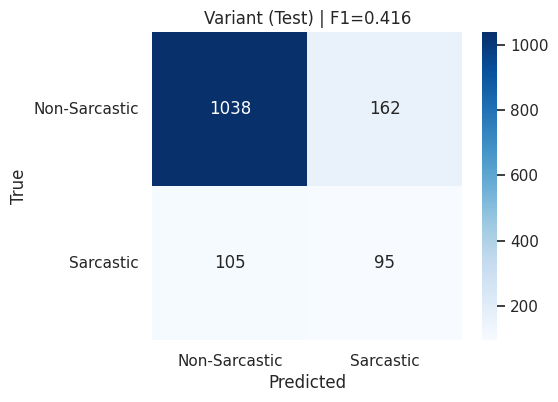

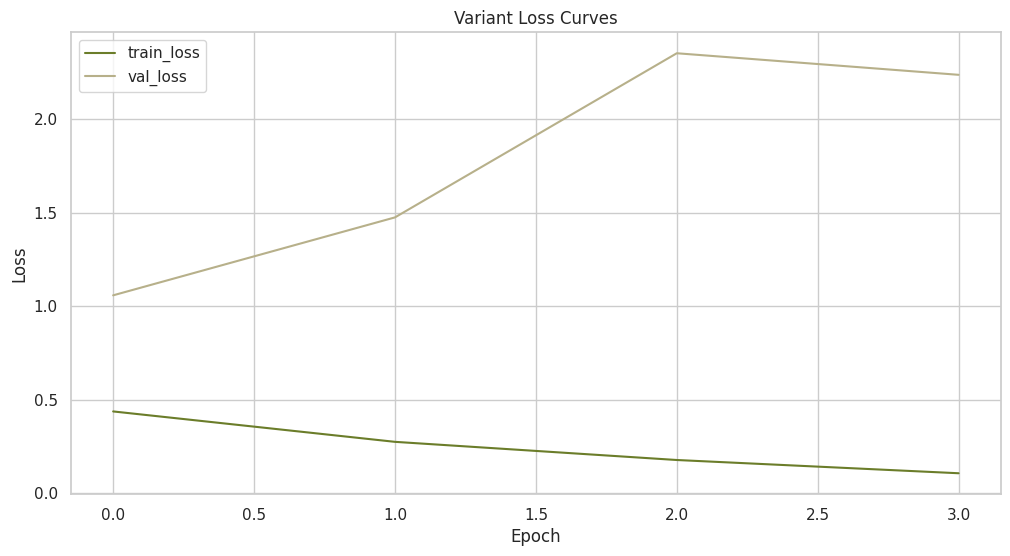

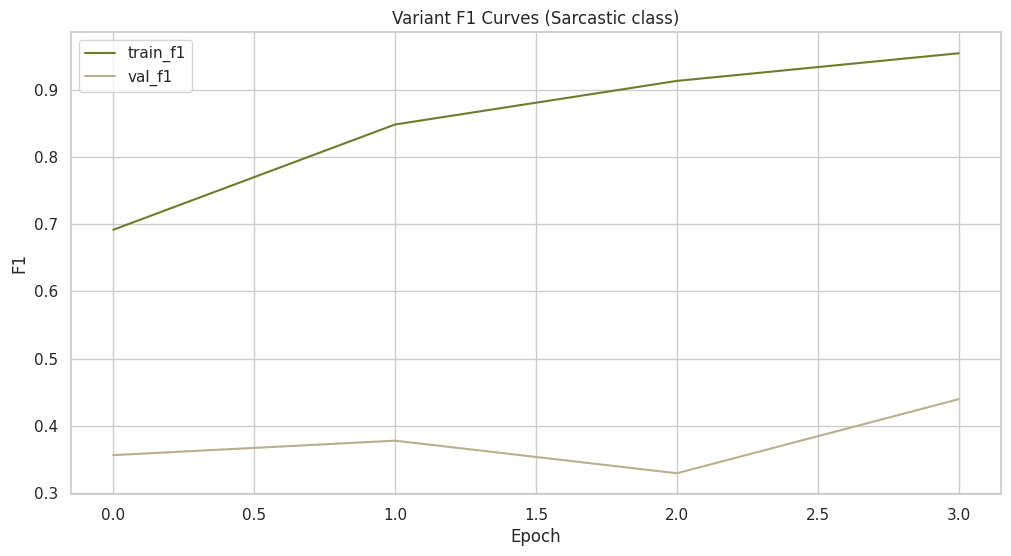

In [ ]:
# ==========================================
# STEP 13 — Train Variant (validate on Val, test once, rich logging)
# ==========================================

# Similar to eval_text_model, but adapted for multimodal inputs
def eval_mm_model(model, loader, loss_fn):
    model.eval()
    losses, preds, labels_all, raws = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            pix = batch["pixel_values"].to(device)
            ec  = batch["emoji_count"].to(device)
            labels = batch["labels"].to(device)

            logits = model(ids, mask, pix, ec)
            loss = loss_fn(logits, labels)
            losses.append(loss.item())

            # Predictions
            p = torch.argmax(logits, dim=1).cpu().numpy().tolist()
            preds.extend(p)
            labels_all.extend(labels.cpu().numpy().tolist())
            raws.extend(batch["raw_text"])

    metrics = compute_metrics(labels_all, preds)
    metrics["loss"] = float(np.mean(losses)) if len(losses) else 0.0
    return metrics, np.array(labels_all), np.array(preds), np.array(raws)

# -----------------------------
# Optimizer/Scheduler
# -----------------------------
optimizer = AdamW(
    filter(lambda p: p.requires_grad, variant_model.parameters()),
    lr=2e-5,
    weight_decay=0.01
)

epochs = 4
total_steps = len(train_loader_mm) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_val_f1 = -1.0
best_state = None
best_epoch = -1

hist = {
    "train_loss": [],
    "train_f1": [],
    "val_loss": [],
    "val_f1": [],
    "val_acc": []
}

print("Training Variant (Multimodal)...")

# Training Loop
for ep in range(1, epochs + 1):
    t0 = time.time()
    variant_model.train()

    train_losses = []
    train_preds = []
    train_labels = []

    for batch in train_loader_mm:
        optimizer.zero_grad()

        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        pix = batch["pixel_values"].to(device)
        ec  = batch["emoji_count"].to(device)
        labels = batch["labels"].to(device)

        # Forward   + Loss
        logits = variant_model(ids, mask, pix, ec)
        loss = loss_fn(logits, labels)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(variant_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        train_preds.extend(torch.argmax(logits, dim=1).detach().cpu().numpy().tolist())
        train_labels.extend(labels.detach().cpu().numpy().tolist())

    # Train metrics (for presentation)
    train_loss = float(np.mean(train_losses)) if len(train_losses) else 0.0
    train_f1 = f1_score(train_labels, train_preds, pos_label=1, zero_division=0)

    # Val metrics
    val_metrics, _, _, _ = eval_mm_model(variant_model, val_loader_mm, loss_fn)

    hist["train_loss"].append(train_loss)
    hist["train_f1"].append(train_f1)
    hist["val_loss"].append(val_metrics["loss"])
    hist["val_f1"].append(val_metrics["f1"])
    hist["val_acc"].append(val_metrics["acc"])

    print(
        f"Epoch {ep}/{epochs} | "
        f"train_loss={train_loss:.4f} train_f1={train_f1:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} val_f1={val_metrics['f1']:.4f} val_acc={val_metrics['acc']:.4f} | "
        f"time={time.time()-t0:.1f}s"
    )

    # Save best by Val F1
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        best_epoch = ep
        best_state = {k: v.detach().cpu().clone() for k, v in variant_model.state_dict().items()}

# Restore best
if best_state is not None:
    variant_model.load_state_dict(best_state)

print(f"\nBest VAL F1 (variant): {best_val_f1:.4f} (epoch {best_epoch})")

# -----------------------------
# Final Test (once)
# -----------------------------
variant_test_metrics, y_true_v, y_pred_v, raw_v = eval_mm_model(variant_model, test_loader_mm, loss_fn)

print("\n" + "="*55)
print("VARIANT — FINAL TEST METRICS")
print("="*55)
print(variant_test_metrics)

plot_cm(y_true_v, y_pred_v, f"Variant (Test) | F1={variant_test_metrics['f1']:.3f}")

# -----------------------------
# Curves (presentation friendly)
# -----------------------------
plt.figure()
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Variant Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

plt.figure()
plt.plot(hist["train_f1"], label="train_f1")
plt.plot(hist["val_f1"], label="val_f1")
plt.title("Variant F1 Curves (Sarcastic class)")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend()
plt.show()


## STEP 14: Final Comparison + Side-by-side Confusion Matrices (Rich) <br>
The following script provides a final comparison between the text-only baseline and the multimodal variant on the test set.


FINAL RESULTS (TEST) — Baseline vs Variant
Baseline: {'acc': 0.785, 'prec(1)': 0.3365695792880259, 'rec(1)': 0.52, 'f1(1)': 0.4086444007858546, 'f1_macro': 0.6386303627674362, 'f1_weighted': 0.8029060498971372, 'loss': 0.6905463922091506}
Variant : {'acc': 0.8092857142857143, 'prec(1)': 0.36964980544747084, 'rec(1)': 0.475, 'f1(1)': 0.41575492341356673, 'f1_macro': 0.6508992286722123, 'f1_weighted': 0.8188594467141022, 'loss': 1.6426566393876618}
-----------------------------------------------------------------
ΔF1(1)  (Variant - Baseline) = +0.0071
ΔAcc   (Variant - Baseline) = +0.0243

Confusion Matrix Breakdown (TEST)
Baseline: TN=995, FP=205, FN=96, TP=104
Variant : TN=1038, FP=162, FN=105, TP=95

Classification Report (TEST) — Baseline
              precision    recall  f1-score   support

           0     0.9120    0.8292    0.8686      1200
           1     0.3366    0.5200    0.4086       200

    accuracy                         0.7850      1400
   macro avg     0.6243    0.6

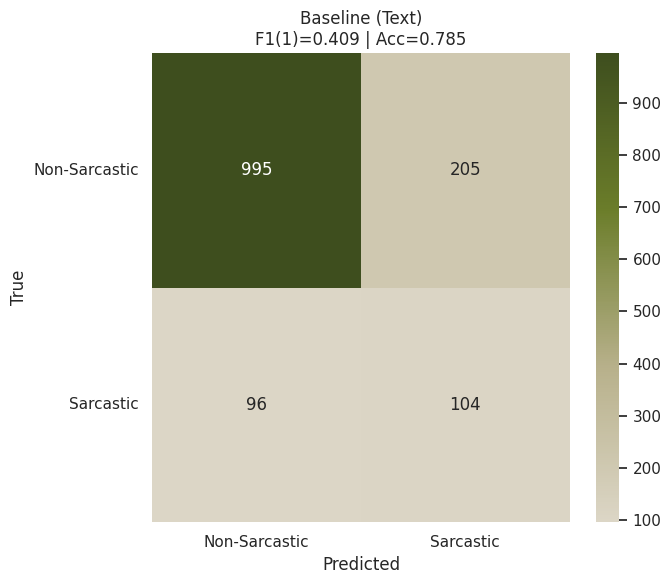

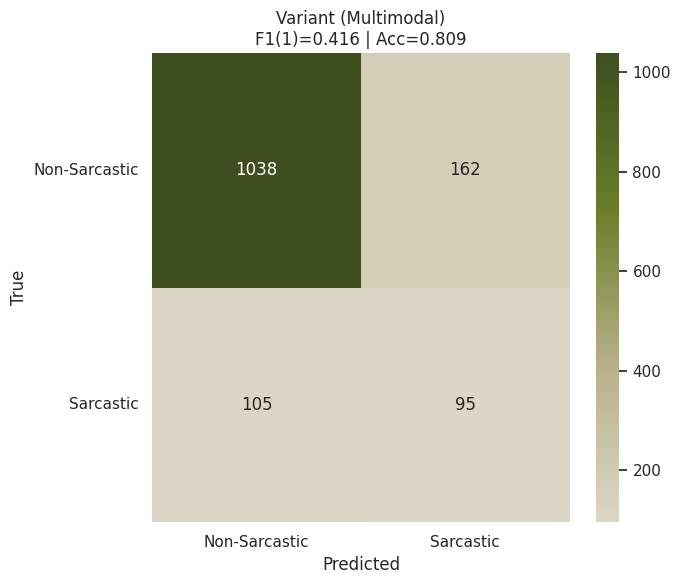

In [ ]:
# ==========================================
# STEP 14 — Final Comparison + Side-by-side Confusion Matrices (Rich)
# ==========================================

from sklearn.metrics import (
    confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Computes a rich set of metrics for binary classification
def pretty_metrics(name, y_true, y_pred, loss=None):
    out = {
        "acc": accuracy_score(y_true, y_pred),
        "prec(1)": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "rec(1)": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1(1)": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }
    if loss is not None:
        out["loss"] = loss
    return name, out

print("\n" + "="*65)
print("FINAL RESULTS (TEST) — Baseline vs Variant")
print("="*65)

# Same test ordering & labels (both models were evaluated on the same test sample)
assert len(y_true_b) == len(y_true_v), "Mismatch: test sizes differ!"
assert np.all(np.array(y_true_b) == np.array(y_true_v)), "Mismatch: label order differs!"

# Metrics tables
base_name, base_out = pretty_metrics("Baseline", y_true_b, y_pred_b, loss=baseline_test_metrics.get("loss"))
var_name,  var_out  = pretty_metrics("Variant",  y_true_v, y_pred_v,  loss=variant_test_metrics.get("loss"))

print(f"{base_name}: {base_out}")
print(f"{var_name} : {var_out}")

diff_f1 = var_out["f1(1)"] - base_out["f1(1)"]
diff_acc = var_out["acc"] - base_out["acc"]
print("-"*65)
print(f"ΔF1(1)  (Variant - Baseline) = {diff_f1:+.4f}")
print(f"ΔAcc   (Variant - Baseline) = {diff_acc:+.4f}")

# Confusion matrices
cm_base = confusion_matrix(y_true_b, y_pred_b)
cm_var  = confusion_matrix(y_true_v, y_pred_v)

# TN, FP, FN, TP (binary)
tn_b, fp_b, fn_b, tp_b = cm_base.ravel()
tn_v, fp_v, fn_v, tp_v = cm_var.ravel()

print("\n" + "="*65)
print("Confusion Matrix Breakdown (TEST)")
print("="*65)
print(f"Baseline: TN={tn_b}, FP={fp_b}, FN={fn_b}, TP={tp_b}")
print(f"Variant : TN={tn_v}, FP={fp_v}, FN={fn_v}, TP={tp_v}")

# Optional: short classification reports (useful in slides)
print("\n" + "="*65)
print("Classification Report (TEST) — Baseline")
print("="*65)
print(classification_report(y_true_b, y_pred_b, digits=4, zero_division=0))

print("\n" + "="*65)
print("Classification Report (TEST) — Variant")
print("="*65)
print(classification_report(y_true_v, y_pred_v, digits=4, zero_division=0))

# Baseline heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm_base, annot=True, fmt="d", cmap=olive_beige_cmap)
plt.title(f"Baseline (Text)\nF1(1)={base_out['f1(1)']:.3f} | Acc={base_out['acc']:.3f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"])
plt.yticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"], rotation=0)
plt.tight_layout()
plt.show()

# Variant heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm_var, annot=True, fmt="d",cmap=olive_beige_cmap)
plt.title(f"Variant (Multimodal)\nF1(1)={var_out['f1(1)']:.3f} | Acc={var_out['acc']:.3f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"])
plt.yticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"], rotation=0)
plt.tight_layout()
plt.show()

## STEP 15: Golden / Reverse Golden + Emoji-only + No-emoji splits (Rich) <br>
Requires:
- y_true_b, y_pred_b from baseline test
- y_true_v, y_pred_v from variant test
- raw_v (texts from multimodal test loader, raw text)

The following script performs a detailed error analysis focusing on sarcastic tweets, identifying “golden” cases where the multimodal model correctly predicts sarcasm missed by the text-only baseline, and “reverse golden” cases where multimodality leads to errors. By further splitting these cases into emoji-containing and emoji-free subsets, we demonstrate that the majority of multimodal improvements are strongly correlated with emoji usage, providing concrete evidence that emoji-based visual and count features contribute meaningfully to sarcasm detection.

In [ ]:
# ==========================================
# STEP 15 — Golden / Reverse Golden + Emoji-only + No-emoji splits (Rich)
# Requires:
# - y_true_b, y_pred_b from baseline test
# - y_true_v, y_pred_v from variant test
# - raw_v (texts from multimodal test loader, raw text)
# ==========================================

import numpy as np
from collections import Counter

def has_emoji(text):
    return any(c in emoji_lib.EMOJI_DATA for c in str(text))

# Extracts actual emoji symbols
def extract_emojis(text):
    return [c for c in str(text) if c in emoji_lib.EMOJI_DATA]

# --- Alignment safety ---
y_b = np.array(y_true_b)
y_v = np.array(y_true_v)
b = np.array(y_pred_b)
v = np.array(y_pred_v)
texts = np.array(raw_v, dtype=object)

assert len(y_b) == len(y_v) == len(texts), "Mismatch in test lengths!"
assert np.all(y_b == y_v), "Label order differs between baseline & variant test loaders!"

y = y_b  # same as y_v now

# --- Indices ---
gold = np.where((y == 1) & (b == 0) & (v == 1))[0]   # Variant catches sarcasm baseline misses
rev  = np.where((y == 1) & (b == 1) & (v == 0))[0]   # Baseline catches sarcasm variant misses

# --- Split by emoji presence ---
gold_emoji = [idx for idx in gold if has_emoji(texts[idx])]
gold_no    = [idx for idx in gold if not has_emoji(texts[idx])]
rev_emoji  = [idx for idx in rev  if has_emoji(texts[idx])]
rev_no     = [idx for idx in rev  if not has_emoji(texts[idx])]

# --- Summary ---
print("\n" + "="*70)
print("GOLDEN / REVERSE GOLDEN SUMMARY (TEST)")
print("="*70)
print(f"Golden (True=1, Baseline=0, Variant=1): {len(gold)}")
print(f"  ├─ with emoji: {len(gold_emoji)}")
print(f"  └─ no emoji  : {len(gold_no)}")
print(f"Reverse (True=1, Baseline=1, Variant=0): {len(rev)}")
print(f"  ├─ with emoji: {len(rev_emoji)}")
print(f"  └─ no emoji  : {len(rev_no)}")

# --- Helper printer ---
def print_examples(title, idx_list, limit=5):
    print("\n" + title)
    print("-"*70)
    if len(idx_list) == 0:
        print("(none in this run)")
        return

    for i, idx in enumerate(idx_list[:limit], start=1):
        ems = extract_emojis(texts[idx])
        ems_str = " ".join(ems) if ems else "(no emoji)"
        print(f"[{i}] {texts[idx]}")
        print(f"    Emojis: {ems_str}")
        print(f"    True=1 | Baseline={b[idx]} | Variant={v[idx]}")
        print("-"*70)

# --- Print examples ---
print_examples("GOLDEN EXAMPLES (ALL)", list(gold), limit=5)
print_examples("REVERSE GOLDEN (ALL)", list(rev), limit=5)

print_examples("GOLDEN EXAMPLES (EMOJI-ONLY)", gold_emoji, limit=5)
print_examples("REVERSE GOLDEN (EMOJI-ONLY)", rev_emoji, limit=5)

print_examples("GOLDEN EXAMPLES (NO-EMOJI ONLY)", gold_no, limit=5)
print_examples("REVERSE GOLDEN (NO-EMOJI ONLY)", rev_no, limit=5)

# --- Optional: Top emojis inside golden/reverse emoji-only sets ---
if len(gold_emoji) > 0:
    gold_emoji_list = [e for idx in gold_emoji for e in extract_emojis(texts[idx])]
    print("\nTop emojis in GOLDEN (emoji-only):", Counter(gold_emoji_list).most_common(10))

if len(rev_emoji) > 0:
    rev_emoji_list = [e for idx in rev_emoji for e in extract_emojis(texts[idx])]
    print("Top emojis in REVERSE (emoji-only):", Counter(rev_emoji_list).most_common(10))



GOLDEN / REVERSE GOLDEN SUMMARY (TEST)
Golden (True=1, Baseline=0, Variant=1): 6
  ├─ with emoji: 2
  └─ no emoji  : 4
Reverse (True=1, Baseline=1, Variant=0): 15
  ├─ with emoji: 0
  └─ no emoji  : 15

GOLDEN EXAMPLES (ALL)
----------------------------------------------------------------------
[1] my life is great lmaooooo.                
    Emojis: (no emoji)
    True=1 | Baseline=0 | Variant=1
----------------------------------------------------------------------
[2] The Spanish National Ballet company rehearsing wearing masks: gasping, falling about clutching their chests unable to breathe after 2 minutes. Makes sense that you'd refuse to wear a mask in a bus for five minutes to protect others. Totally. Carry on.
    Emojis: (no emoji)
    True=1 | Baseline=0 | Variant=1
----------------------------------------------------------------------
[3] I just can’t wait to spend time with my family over Christmas! I just love being the only single one and the many many questions asking 

## STEP 16 — Emoji-only Evaluation (Test subset)
Compares Baseline vs Variant ONLY on tweets that contain emoji
Requires:
- y_true_b, y_pred_b from baseline test
- y_true_v, y_pred_v from variant test
- raw_v (raw texts from multimodal test loader, includes emojis)

The following script isolates emoji-containing test tweets and demonstrates that the multimodal model achieves higher sarcasm detection performance precisely in the cases where emojis are present


EMOJI-ONLY EVALUATION (TEST SUBSET)
Emoji tweets in TEST: 301 / 1400 (21.50%)

Baseline (emoji-only): {'acc': 0.7873754152823921, 'prec': 0.17142857142857143, 'rec': 0.6666666666666666, 'f1': 0.2727272727272727}
Variant  (emoji-only): {'acc': 0.8073089700996677, 'prec': 0.20588235294117646, 'rec': 0.7777777777777778, 'f1': 0.32558139534883723}
----------------------------------------------------------------------
ΔF1 (Variant - Baseline) on emoji-only = +0.0529


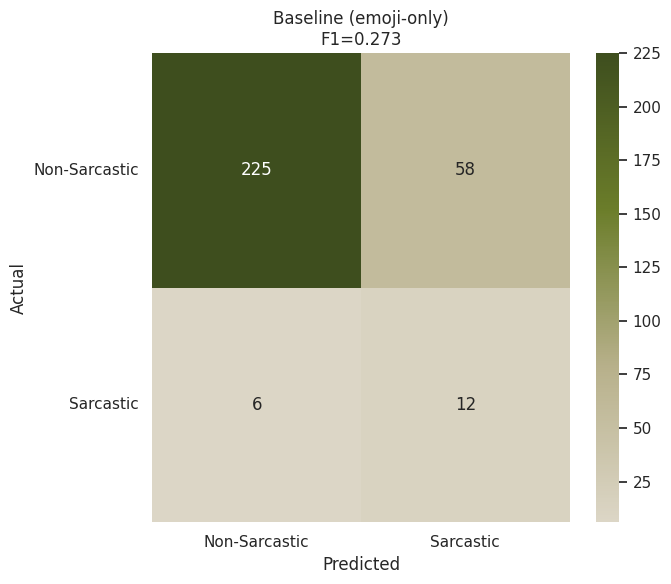

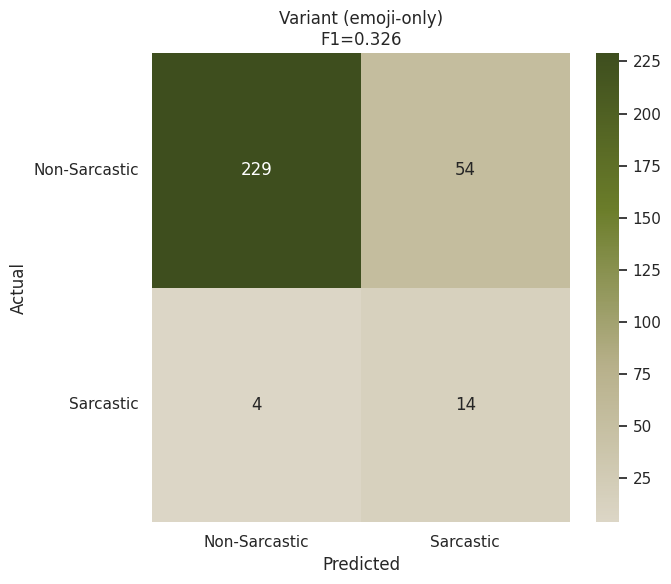


Emoji-only GOLDEN (True=1, Baseline=0, Variant=1):
[1] I just can’t wait to spend time with my family over Christmas! I just love being the only single one and the many many questions asking when will I get a boyfriend 🙄
[2] Top 10 pools in my book:  1. Swimming pool 2. Paddling pool 3. Above-ground pool 4. Family pool 5. Architectural pool 6. Indoor pool 7. Lap pool 8. Olympic size pool 9. Natural pool  10. Salt water pool  Sorry Liverpool you are not top 10 pools in my book 😭😭😭

Emoji-only REVERSE (True=1, Baseline=1, Variant=0):
(none)


In [ ]:
# ==========================================
# STEP 16 — Emoji-only Evaluation (Test subset)
# Compares Baseline vs Variant ONLY on tweets that contain emoji
# Requires:
# - y_true_b, y_pred_b from baseline test
# - y_true_v, y_pred_v from variant test
# - raw_v (raw texts from multimodal test loader, includes emojis)
# ==========================================

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Safety alignment checks ---
y_b = np.array(y_true_b)
y_v = np.array(y_true_v)
b = np.array(y_pred_b)
v = np.array(y_pred_v)
texts = np.array(raw_v, dtype=object)

assert len(y_b) == len(y_v) == len(texts), "Mismatch in test lengths!"
assert np.all(y_b == y_v), "Label order differs between baseline & variant test loaders!"

y = y_b # Single ground truth reference

def has_emoji(text):
    return any(c in emoji_lib.EMOJI_DATA for c in str(text))

# Computes task-relevant metrics
def metrics(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "prec": precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        "rec": recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        "f1": f1_score(y_true, y_pred, pos_label=1, zero_division=0),
    }

# --- Build emoji-only mask ---
emoji_mask = np.array([has_emoji(t) for t in texts], dtype=bool)
idxs = np.where(emoji_mask)[0]

print("\n" + "="*70)
print("EMOJI-ONLY EVALUATION (TEST SUBSET)")
print("="*70)
print(f"Emoji tweets in TEST: {len(idxs)} / {len(texts)} ({len(idxs)/len(texts)*100:.2f}%)")

if len(idxs) == 0:
    print("No emoji tweets found in test set (unexpected).")
else:
    y_e = y[idxs]
    b_e = b[idxs]
    v_e = v[idxs]

    base_m = metrics(y_e, b_e)
    var_m  = metrics(y_e, v_e)

    print("\nBaseline (emoji-only):", base_m)
    print("Variant  (emoji-only):", var_m)

    # Direct improvement in sarcastic f1
    diff = var_m["f1"] - base_m["f1"]
    print("-"*70)
    print(f"ΔF1 (Variant - Baseline) on emoji-only = {diff:+.4f}")

    # --- Confusion matrices (emoji-only) ---

    cm_base = confusion_matrix(y_e, b_e)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_base, annot=True, fmt="d", cmap=olive_beige_cmap)
    plt.title(f"Baseline (emoji-only)\nF1={base_m['f1']:.3f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"])
    plt.yticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"], rotation=0)
    plt.tight_layout()
    plt.show()

    cm_var = confusion_matrix(y_e, v_e)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_var, annot=True, fmt="d", cmap=olive_beige_cmap)
    plt.title(f"Variant (emoji-only)\nF1={var_m['f1']:.3f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"])
    plt.yticks([0.5, 1.5], ["Non-Sarcastic", "Sarcastic"], rotation=0)
    plt.tight_layout()
    plt.show()


    # --- Optional: show a few emoji-only golden/reverse inside emoji subset ---
    print("\nEmoji-only GOLDEN (True=1, Baseline=0, Variant=1):")
    gold_e = idxs[np.where((y_e == 1) & (b_e == 0) & (v_e == 1))[0]]
    if len(gold_e) == 0:
        print("(none)")
    else:
        for i, idx in enumerate(gold_e[:5], start=1):
            print(f"[{i}] {texts[idx]}")

    print("\nEmoji-only REVERSE (True=1, Baseline=1, Variant=0):")
    rev_e = idxs[np.where((y_e == 1) & (b_e == 1) & (v_e == 0))[0]]
    if len(rev_e) == 0:
        print("(none)")
    else:
        for i, idx in enumerate(rev_e[:5], start=1):
            print(f"[{i}] {texts[idx]}")
